In [1]:
library(readxl)

prb <- read_excel('../data/prb_10-9-2020.xlsx', sheet = 'K-PRB')

Warning message:
"Expecting numeric in D1059 / R1059C4: got 'na'"
New names:
• `Rb` -> `Rb...38`
• `Sr` -> `Sr...40`
• `Th` -> `Th...42`
• `U` -> `U...43`
• `Hf` -> `Hf...45`
• `Pb` -> `Pb...59`
• `Nd` -> `Nd...65`
• `Sm` -> `Sm...66`
• `Lu` -> `Lu...76`
• `Rb` -> `Rb...79`
• `Sr` -> `Sr...80`
• `Sm` -> `Sm...87`
• `Nd` -> `Nd...88`
• `Lu` -> `Lu...94`
• `Hf` -> `Hf...95`
• `U` -> `U...100`
• `Th` -> `Th...101`
• `Pb` -> `Pb...102`


In [2]:
library(tidyverse)

primaries <- select(prb,
    # Major Elements
    "SiO2",
    "TiO2", 
    "Al2O3", 
    "FeO(tot)*", 
    "CaO", 
    "MgO", 
    "K2O", 
    "Na2O",
)

# Coerce fields with values like "> 0.10" to numeric "0.10"
numerical_data <- mutate_at(primaries, vars(-group_cols()), ~ as.numeric(stringr::str_replace_all(., "<", "")))

# numerical_data <- primaries %>% select_if(is.numeric) # Filter out non-numerical fields

# Filter out data with missing values
data <- numerical_data[complete.cases(numerical_data), ]
sprintf('Number of samples: %s', nrow(data))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] "Number of samples: 532"

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

corrplot 0.92 loaded



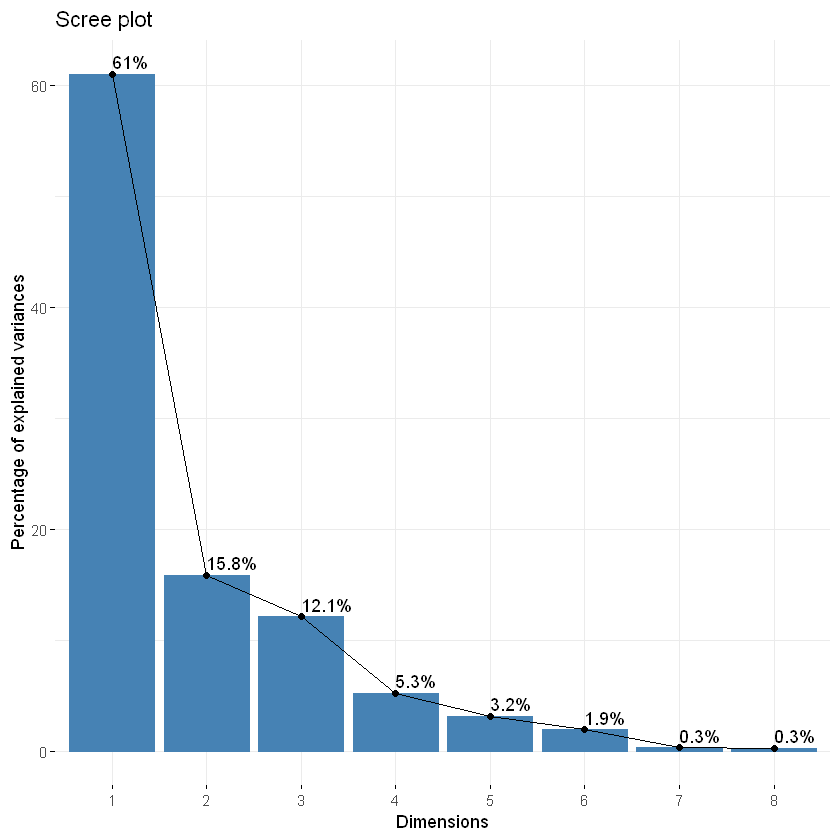

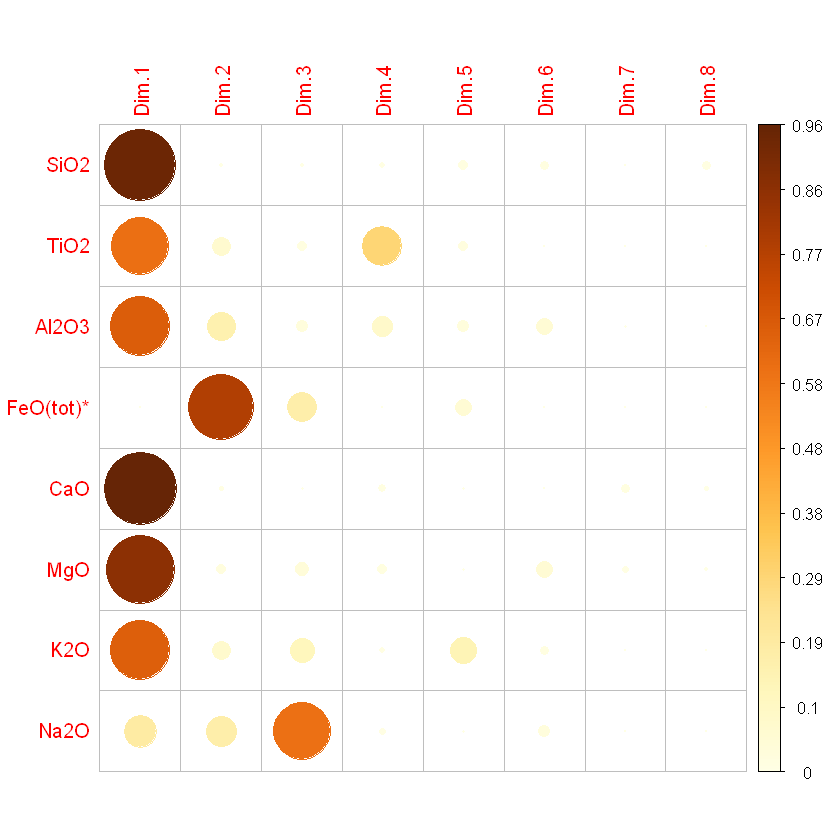

In [3]:
library(factoextra)
library(corrplot)

pca <- prcomp(data, scale = TRUE)
var <- get_pca_var(pca)
ind <- get_pca_ind(pca)

fviz_eig(pca, addlabels = TRUE)
corrplot(var$cos2, is.corr=FALSE)


[1] "RMSE: 1.88947682598734"

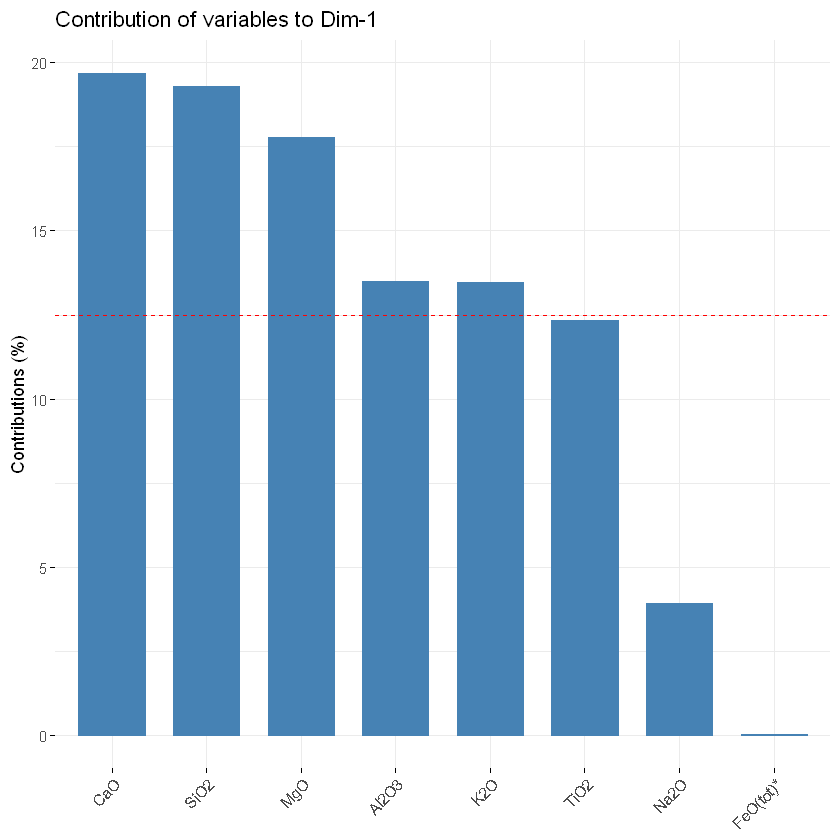

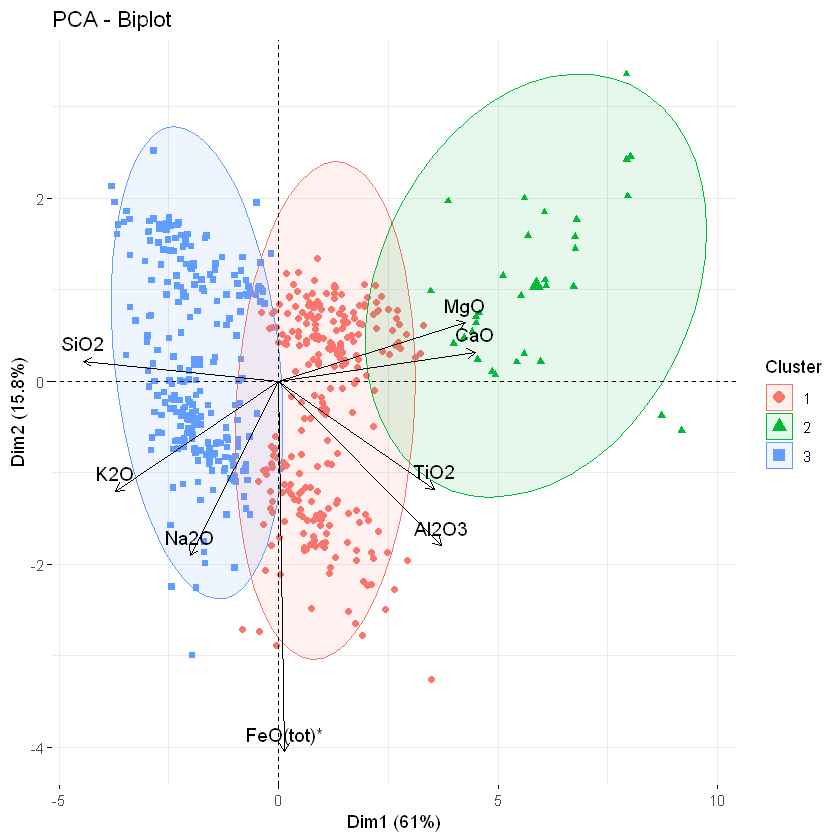

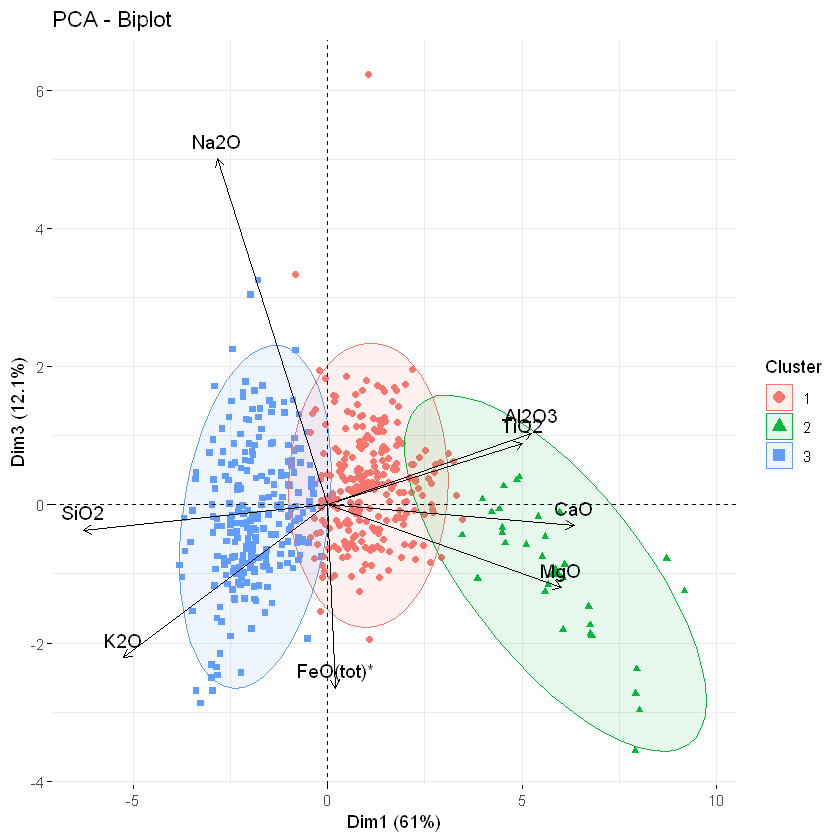

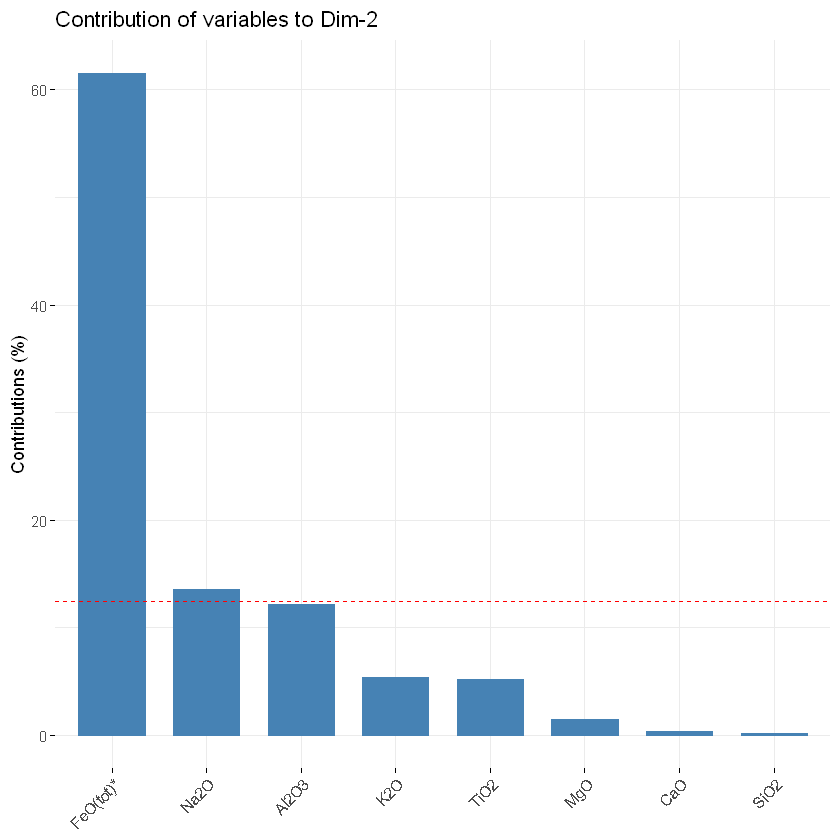

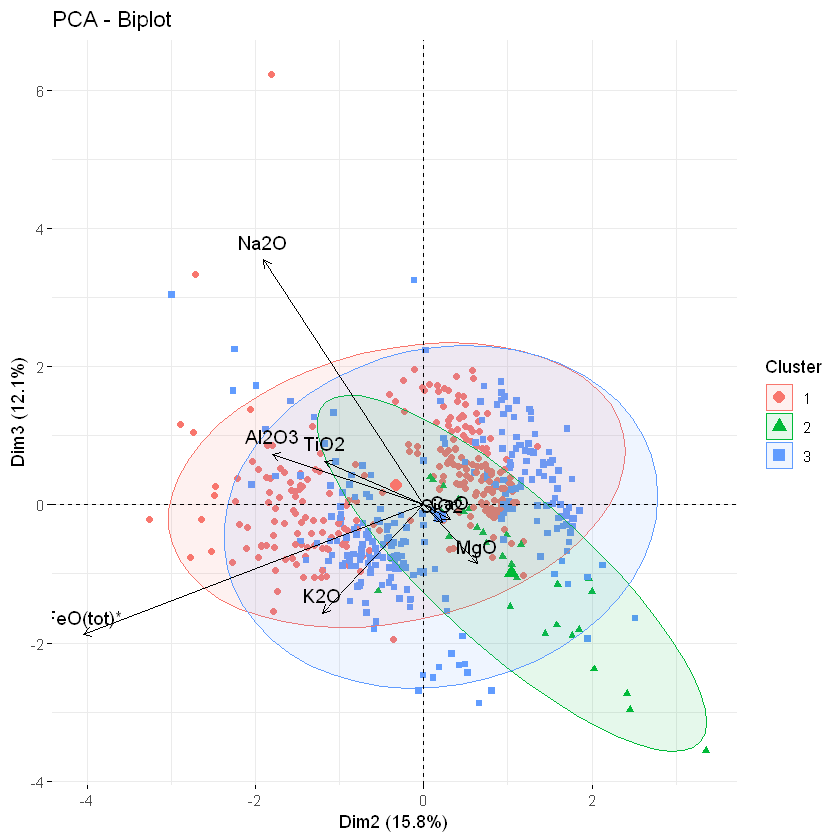

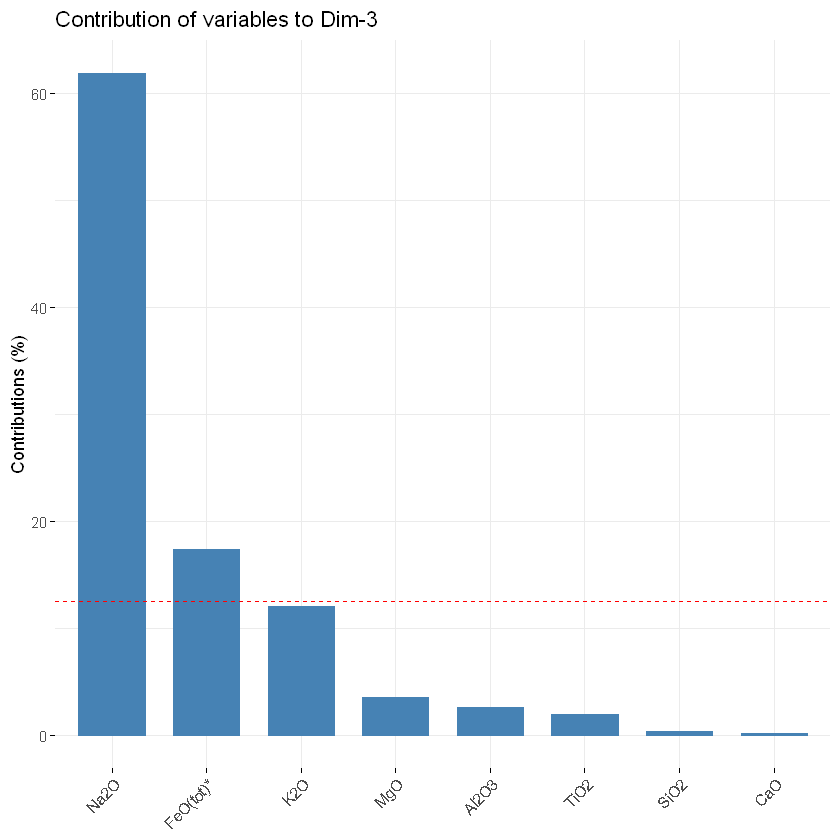

In [4]:
dim <- 3

set.seed(123)
km_var <- kmeans(var$coord, centers = dim, nstart = 25)
km_ind <- kmeans(ind$coord, centers = dim, nstart = 25)
km_var.grp <- as.factor(km_var$cluster)
km_ind.grp <- as.factor(km_ind$cluster)

rmse_ind <- sqrt(sum(km_ind$withinss) / nrow(ind$coord))
sprintf('RMSE: %s', rmse_ind)

for (i in 1:dim) {

  print(fviz_contrib(pca, choice = "var", axes = i))

  for (k in 1:dim) {
    if (k <= i) next

    print(fviz_pca(pca, 
      col.ind = km_ind.grp,
      col.var = 'black',
      geom.ind = "point",
      addEllipses = TRUE, 
      legend.title = "Cluster",
      axes = c(i, k)
    ))

    # print(fviz_pca_var(
    #   pca, 
    #   col.var = 'cos2', 
    #   gradient.cols = c('#00AFBB', '#E7B800', '#FC4E07'), 
    #   repel = TRUE,
    #   axes = c(i, k)
    # ))
  }
}

In [5]:
options(rgl.useNULL = TRUE)
library(rgl)

scores <- as.data.frame(pca$x)

plot3d(scores[, 1:3], col = km_ind.grp, main = "PCA Scores", size=5)
text3d(pca$rotation[, 1:3], texts = colnames(data), cex = 0.8, col = "red")

coords <- NULL
for (i in 1:nrow(pca$rotation)) {
  coords <- rbind(coords,
                rbind(c(0, 0, 0),
                    pca$rotation[i, 1:3]
                )
            )
}

lines3d(coords, col='red', lwd=1)

widget <- rglwidget(width=1000, height=1000)

htmlwidgets::saveWidget(widget,
    file = "../plots/prb_pca.html", 
    libdir = "../plots/lib",
    selfcontained = TRUE
)

Warning message:
"package 'rgl' was built under R version 4.2.3"
